### Import libraries

In [1]:
import sys
sys.path.append("..")

In [2]:
from model import classic_model_mh, classic_model, losses, dot_prod_attention
from data import data_generation, batch_creator, gp_kernels, gp_priors
from keras.callbacks import ModelCheckpoint
from helpers import helpers, masks, metrics
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from inference import infer
import tensorflow as tf
import numpy as np
import matplotlib 
import time
import keras
plt.style.use('ggplot')

/Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


In [3]:
save_dir = '/Users/omernivron/Downloads/GPT'

In [4]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generation.data_generator_for_gp_mimick_gpt(150000, ordered = False)

m = np.mean(pad_pos_tr)
std = np.std(pad_pos_tr)
m_y = np.mean(pad_y_fren_tr)
std_y = np.std(pad_y_fren_tr)

pad_pos_tr = (pad_pos_tr - m) / std
pad_pos_te = (pad_pos_te - m) / std
pad_y_fren_tr = (pad_y_fren_tr - m_y) / std_y
pad_y_fren_te = (pad_y_fren_te - m_y) / std_y

In [5]:
loss_object = tf.keras.losses.MeanSquaredError()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')
m_tr = tf.keras.metrics.Mean()
m_te = tf.keras.metrics.Mean()

In [6]:
@tf.function
def train_step(decoder, optimizer_c, train_loss, m_tr, pos, tar):
    '''
    A typical train step function for TF2. Elements which we wish to track their gradient
    has to be inside the GradientTape() clause. see (1) https://www.tensorflow.org/guide/migrate 
    (2) https://www.tensorflow.org/tutorials/quickstart/advanced
    ------------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask (np array): see description in position_mask function
    ------------------    
    '''
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    combined_mask_pos = masks.create_masks(pos)
    combined_mask_tar = masks.create_masks(tar_inp)


    with tf.GradientTape(persistent=True) as tape:
#         pred, pred_log_sig = decoder(pos, tar_inp, True, pos_mask, combined_mask_tar)
        # starting from 9 means we want to have the first 10 traget r.v y as static 
        # and they are not going to be part of the loss calculation
        pred = decoder(pos, tar_inp, True, combined_mask_pos , combined_mask_tar)


# 
#         loss, mse, mask = losses.loss_function(tar_real, pred, pred_log_sig)
        loss, mse, mask = losses.loss_function(tar_real[:, 9:], pred = pred[:, 9:, 0], pred_log_sig = pred[:, 9:, 1])



    gradients = tape.gradient(loss, decoder.trainable_variables)
    # Ask the optimizer to apply the processed gradients.
    optimizer_c.apply_gradients(zip(gradients, decoder.trainable_variables))
    train_loss(loss)
    m_tr.update_state(mse, mask)
    return pred[:, 9:, 0], pred[:, 9:, 1]

In [7]:
@tf.function
def test_step(decoder, test_loss, m_te, pos_te, tar_te):
    '''
    
    ---------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask_te (np array): see description in position_mask function
    ---------------
    
    '''
    tar_inp_te = tar_te[:, :-1]
    tar_real_te = tar_te[:, 1:]
    combined_mask_pos_te = masks.create_masks(pos_te)
    combined_mask_tar_te = masks.create_masks(tar_inp_te)    
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
#   pred = decoder(pos_te, tar_inp_te, False, pos_mask_te, combined_mask_tar_te)


#     pred, pred_log_sig = decoder(pos_te, tar_inp_te, False, pos_mask_te, combined_mask_tar_te)
    pred_te = decoder(pos_te, tar_inp_te, False, combined_mask_pos_te, combined_mask_tar_te)


#     t_loss, t_mse, t_mask = losses.loss_function(tar_real_te, pred, pred_log_sig)
    t_loss, t_mse, t_mask = losses.loss_function(tar_real_te[:, 9:], pred = pred_te[:, 9:, 0], pred_log_sig = pred_te[:, 9:, 1])

    test_loss(t_loss)
    m_te.update_state(t_mse, t_mask)
    return pred_te[:, 9:, 0], pred_te[:, 9:, 1]

In [8]:
tf.keras.backend.set_floatx('float64')

In [9]:
if __name__ == '__main__':
    writer = tf.summary.create_file_writer(save_dir + '/logs/')
    optimizer_c = tf.keras.optimizers.Adam()
    decoder = classic_model.Decoder(64)
    EPOCHS = 750
    batch_s  = 64
    run = 1; step = 0
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    tf.random.set_seed(1)   
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    main_folder = "/Users/omernivron/Downloads/GPT/ckpt/check_"
    folder = main_folder + str(run); helpers.mkdir(folder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    with writer.as_default():
        for epoch in range(EPOCHS):
            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                m_te.reset_states(); test_loss.reset_states()
                batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=64)
                # batch_tar_tr shape := 128 X 59 = (batch_size, max_seq_len)
                # batch_pos_tr shape := 128 X 59 = (batch_size, max_seq_len)
#                 batch_pos_mask = masks.position_mask(batch_pos_tr)
#                 print(batch_pos_mask.shape)
#                 print(batch_pos_mask)
                pred, pred_log = train_step(decoder, optimizer_c, train_loss, m_tr, batch_pos_tr, batch_tar_tr)
                
                if batch_n % 50 == 0:
                    batch_pos_te, batch_tar_te, _ = batch_creator.create_batch_gp_mim_2(pad_pos_te, pad_y_fren_te, batch_s=64)
                    pred_te, pred_log_te = test_step(decoder, test_loss, m_te, batch_pos_te, batch_tar_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Already exists
Restored from /Users/omernivron/Downloads/GPT/ckpt/check_1/ckpt-476
v_p:  Tensor("decoder/wk_1/BiasAdd:0", shape=(64, 59, 64), dtype=float64)
pos_attn1 : Tensor("decoder/transpose_1:0", shape=(64, 58, 64), dtype=float64)
q : Tensor("decoder/hq/BiasAdd:0", shape=(64, 58, 64), dtype=float64)
tar mask : Tensor("Maximum_1:0", shape=(64, 58, 58), dtype=float32)
tar_attn1 : Tensor("decoder/MatMul_1:0", shape=(64, 58, 64), dtype=float64)
L : Tensor("decoder/Add_2:0", shape=(64, 58, 64), dtype=float64)
v_p:  Tensor("decoder/wk_1/BiasAdd:0", shape=(64, 59, 64), dtype=float64)
pos_attn1 : Tensor("decoder/transpose_1:0", shape=(64, 58, 64), dtype=float64)
q : Tensor("decoder/hq/BiasAdd:0", shape=(64, 58, 64), dtype=float64)
tar mask : Tensor("Maximum_1:0", shape=(64, 58, 58), dtype=float32)
tar_attn1 : Tensor("decoder/MatMul_1:0", shape=(64, 58, 64), dtype=float64)
L : Tensor("decoder/Add_2:0", shape=(64, 58, 64), dtype=float64)
v_p:  Tensor("decoder/wk_1/BiasAdd:0", shape=(64, 59,

KeyboardInterrupt: 

In [11]:
infer.inference(decoder, pos = batch_pos_tr[1, :10].reshape(1, -1), tar = batch_tar_tr[1, :9].reshape(1, -1))

v_p:  tf.Tensor(
[[[-3.43664280e-01  1.27870453e-02  7.72738121e-02 -3.05646617e-01
    1.23060791e-02  3.38346651e-01 -2.11548724e-01 -8.53710753e-02
   -2.44009891e-01  8.38990034e-02 -8.31369753e-01  8.25259785e-01
   -2.80485878e-03 -5.78673229e-01  2.00571938e-01  1.02420834e-01
   -2.06052931e-01  1.52850265e-01  4.09876291e-02 -3.57301612e-02
    2.25627252e-02  1.54819142e+00  2.55376406e-01  3.74007090e-01
   -1.31628412e-01  3.67242750e-03 -2.58306150e-01 -2.41817152e-01
   -1.77078906e-01 -7.75995432e-01  5.85324445e-02 -8.85895218e-02
    2.88727606e-02  7.17318365e-01 -1.34496735e-01 -9.44869579e-01
    1.12428825e-01 -2.25263167e-01 -2.58011306e-02  4.15126589e-01
   -3.13805108e-01  5.12164721e-02  2.21440651e-01  8.10168280e-01
    5.59539202e-04  3.11002608e-01 -2.53918731e-01  1.48005134e-01
   -4.92612159e-02 -2.42529051e-01 -9.25310323e-01  5.58539955e-01
    8.66738504e-01  1.06046626e+00 -1.46742966e-02 -2.89141485e-01
   -4.63322591e-01 -3.30529352e-01  1.5825243

InvalidArgumentError: Matrix size-incompatible: In[0]: [64,10], In[1]: [59,58] [Op:MatMul]

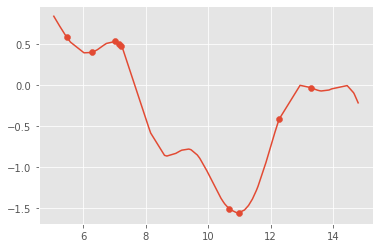

In [11]:
sorted_arr = np.argsort(batch_pos_tr[1, :])
plt.scatter(batch_pos_tr[1, :9], batch_tar_tr[1, :9])
plt.plot(batch_pos_tr[1, sorted_arr], batch_tar_tr[1, sorted_arr])

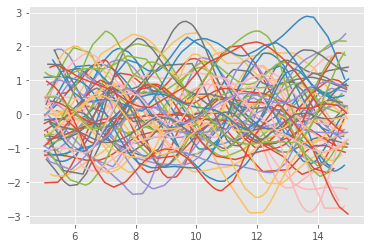

In [20]:
for i in range(batch_pos_tr.shape[0]):
    plt.plot(batch_pos_tr[i, :], batch_tar_tr[i, :])

In [19]:
extrapo = True

In [ ]:
if extrapo:
    x = np.load('/Users/omernivron/Downloads/GPT_data_goldstandard/x_extra.npy')
    y = np.load('/Users/omernivron/Downloads/GPT_data_goldstandard/y_extra.npy')
else:
    x = np.load('/Users/omernivron/Downloads/GPT_data_goldstandard/x_interpol.npy')
    y = np.load('/Users/omernivron/Downloads/GPT_data_goldstandard/y_interpol.npy')

In [28]:
mse_metric = 0; r_sq_metric = 0; kuee_metric = 0;
μ = []; σ = []
m = int(x.shape[0] / 10)
y_mean = np.mean(y[:m, :40])
y_te = y[:m, 40]
for j in range(0, m):
    x_tr = x[j, :41].reshape(1, -1)
    y_tr = y[j, :40].reshape(1, -1)
    μ_te = infer.inference(decoder, x_tr, y_tr)
#     μ_te, log_σ_te = infer.inference(decoder, x_tr, y_tr, mh=True)


    μ.append(μ_te[0][-1].numpy()); 
#     σ.append(log_σ_te[-1])
#     kuee_metric += metrics.KUEE(y_te[j], μ_te[-1], np.exp(log_σ_te[-1]))
#     if (j % 400 == 0): 
#         print('J: ', j)
#         axes = plt.gca()
#         axes.set_ylim([-2, 2])
#         plt.scatter(x_tr[:, :-1], y_tr, c = 'black')
#         plt.scatter(x_tr[:, 1:], μ_te, c='navy')
#         plt.scatter(x_tr[:, -1], y_te[j], c='purple')
#         plt.scatter(x_tr[:, -1], μ_te[-1], c='red')
# #         plt.errorbar(x = x_tr[:, 40], y = (μ_te[-1]), yerr = 2 * np.exp(log_σ_te[-1]), fmt='o', ecolor='g', capthick=2)


        
        
# #         plt.fill_between(x_tr[:, 1:].squeeze(), μ_te -2 * np.exp(log_σ_te), μ_te  + 2 * np.exp(log_σ_te), alpha=.2)

#         plt.show()
    
mse_metric = metrics.mse(y_te, μ) 
r_sq_metric = metrics.r_squared(y_te, μ, y_mean)  
mse_metric *= (1 / m)
# kuee_metric *= (1 / m)

In [29]:
r_sq_metric

0.5012839537371766

In [30]:
    mse_metric

0.4851938633914596

In [29]:
t = tf.constant([[1, 1, 1]])
t1 = tf.constant([[2, 0, 0]])

In [24]:
masks.create_look_ahead_mask(10)

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [26]:
tf.linalg.band_part(tf.ones((5, 5)), -1, 0)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [30]:
tf.multiply(t, t1)

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 0, 0]], dtype=int32)>

In [39]:
tf.repeat((1,1), 21)

<tf.Tensor: shape=(42,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)>

In [51]:
tf.constant(tf.repeat(0, 9), shape=(1, 9))

<tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>

In [64]:
a = tf.repeat(tf.concat([tf.constant(tf.repeat(0, 10), shape=(1, 10)), tf.constant(tf.repeat(1, 21), shape=(1, 21))], axis = 1), 64, axis=0)

In [66]:
a[30]

<tf.Tensor: shape=(30,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>

In [ ]:
tf.transpose